## Modeling
### Experiments with Tree-based Scikit-learn models

**Objective**: The primary objective of this notebook is to perform experimentation with the tree-based models for multi-step ahead forecasting.



In [1]:
import sys
import os

# Get the directory of the current notebook
notebook_dir = os.path.dirname(os.path.abspath("__file__"))  # Use __file__ for portability

# Move up one level to the project root
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))

# Change working directory
os.chdir(project_root)

# Verify the change
print(os.getcwd()) 

/home/michel/projects/tree-based-forecasting-boilerplate


In [2]:
%load_ext autoreload
%autoreload 2

from scripts.run_wfv import *
from src.models.train_model import *
from src.models.evaluate_model import *
from src.models.predict_model import *
from src.visualization.data_viz import *

In [3]:
logger.setLevel("WARNING")

In [4]:
models_list = [model_config["available_models"][0]]
ticker_list = [data_config["ticker_list"][0]]

In [35]:
def walk_forward_validation(load_best_params, models_list, ticker_list, wfv_steps=0, wfv_size=FORECAST_HORIZON, write_to_table=True) -> pd.DataFrame:
    """
    Performs Walkf Forward Validation, i.e, training and testing the models
    in multiple time-frames.
    """

    validation_report_df = pd.DataFrame()

    logger.debug("Loading the featurized dataset..")
    feature_df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, PROCESSED_DATA_NAME), parse_dates=["DATE"])


    for ticker in ticker_list:
        filtered_feature_df = feature_df[feature_df[CATEGORY_COL] == ticker].copy().drop(CATEGORY_COL, axis=1)
        
        for model_type in models_list:
            logger.info(f"Performing model cross validation for ticker symbol [{ticker}] using model [{model_type}]...")

            wfv_start_date = filtered_feature_df["DATE"].max() - relativedelta(days=wfv_size*wfv_steps)
            step_df = filtered_feature_df[filtered_feature_df["DATE"] <= wfv_start_date].copy()

            logger.info(f"WFV with {wfv_steps} steps and step size equal to {wfv_size}...")
            logger.info(f"Start training date: {step_df['DATE'].max()}")

            for step in range(wfv_steps+1):
                logger.info(f"Iteration [{step}] training date: {step_df['DATE'].max()}")

                predictions_df, X_testing_df = stepwise_prediction(
                    X=step_df.drop(columns=[TARGET_COL]),
                    y=step_df[TARGET_COL],
                    forecast_horizon=FORECAST_HORIZON,
                    model_type=model_type,
                    ticker=ticker,
                    load_best_params=load_best_params
                )

                predictions_df[CATEGORY_COL] = ticker
                predictions_df["TRAINING_DATE"] = dt.datetime.today().date()
                validation_report_df = pd.concat([validation_report_df, predictions_df], axis=0)

                # Add the previous testing dates to the training dataset
                step_df = filtered_feature_df[filtered_feature_df["DATE"] <= (wfv_start_date + relativedelta(days=wfv_size * (step + 1)))].copy()

    
    if write_to_table:
        logger.info("Writing the testing results dataframe...")
        file_path = os.path.join(OUTPUT_DATA_PATH, 'wfv_'+CROSS_VAL_DATA_NAME)

        if os.path.isfile(file_path):
            validation_report_df.to_csv(file_path, mode='a', header=False, index=False)
        else:
            validation_report_df.to_csv(file_path, index=False)

    return validation_report_df

In [34]:
def update_test_values(X: pd.DataFrame, y: pd.Series, day: int) -> tuple[pd.DataFrame, pd.Series]:
    """
    Prepares the feature and target data for testing on a specific day.

    This function extracts a single row (or the remaining rows if it's the last day) 
    from the input feature DataFrame (X) and target Series (y) to create a test set for 
    a specific day. The day is specified relative to the end of the DataFrame, where
    day 1 represents the last day, day 2 the second-to-last day, and so on.

    Args:
        X (pd.DataFrame): The feature DataFrame containing all historical data.
        y (pd.Series): The target Series containing all historical target values.
        day (int): The day to extract for testing, relative to the end of the DataFrames.
                   1 is the last day, 2 is the second-to-last, etc.

    Returns:
        tuple[pd.DataFrame, pd.Series]: A tuple containing:
            - X_test (pd.DataFrame): A DataFrame with the features for the specified day.
            - y_test (pd.Series): A Series with the target value for the specified day.

    Raises:
        IndexError: If the specified `day` is out of bounds for the input DataFrames.
    """
    if day != 1:
        # Select a single row using negative indexing
        X_test = X.iloc[-day:-day+1,:]
        y_test = y.iloc[-day:-day+1]

    else:
        # Handle the special case of the last day (day 1)
        X_test = X.iloc[-day:,:]
        y_test = y.iloc[-day:]

    X_test.reset_index(drop=True, inplace=True)

    return X_test, y_test


def calculate_metrics(pred_df, actuals, predictions):
    logger.debug("Calculating the evaluation metrics...")
    
    model_mape = round(mean_absolute_percentage_error(actuals, predictions), 4)
    model_rmse = round(np.sqrt(mean_squared_error(actuals, predictions)), 2)
    model_mae = round(mean_absolute_error(actuals, predictions), 2)
    model_wape = round((pred_df.ACTUAL - pred_df.FORECAST).abs().sum() / pred_df.ACTUAL.sum(), 2)

    pred_df["MAPE"] = model_mape
    pred_df["MAE"] = model_mae
    pred_df["WAPE"] = model_wape
    pred_df["RMSE"] = model_rmse

    return pred_df


def stepwise_prediction(X: pd.DataFrame, y: pd.Series, forecast_horizon: int, model_type: Any, ticker: str, load_best_params: bool = False) -> pd.DataFrame:
    """
    Performs iterativly 1 step ahead forecast validation for a given model type and ticker symbol.

    This function iteratively trains a model on historical data, then forecasts into the future using a sliding window approach.
    The forecast horizon is adjusted to exclude weekends. It returns a DataFrame with the actual and predicted values, along with performance metrics.

    Args:
        X (pd.DataFrame): Feature matrix.
        y (pd.Series): Target variable.
        forecast_horizon (int): The number of days to forecast ahead.
        model_type (Any): The type of model to use (e.g., 'xgb', 'rf', 'et').
        ticker (str): The stock ticker symbol.
        tune_params (bool, optional): Whether to perform hyperparameter tuning. Defaults to False.

    Returns:
        pd.DataFrame: A DataFrame containing:
            - DATE: The dates of the predictions.
            - ACTUAL: The actual target values.
            - PREDICTED_COL: The predicted values.
            - MODEL_TYPE: The type of model used.
            - CLASS: "Testing" (indicates the type of data).
            - Additional columns with performance metrics (MAE, RMSE, MAPE).
    """

    # Create empty list for storing each prediction
    predictions = []
    actuals = []
    dates = []
    X_testing_df = pd.DataFrame()

    forecast_horizon = weekend_adj_forecast_horizon(forecast_horizon, 2)
    
    # get the one-shot training set
    X_train = X.iloc[:-forecast_horizon, :]
    y_train = y.iloc[:-forecast_horizon]
    final_y = y_train.copy()

    logger.debug(f"Training model until (including): {X_train["DATE"].max().date()}")

    best_model = train_model(
        X_train.drop(columns=["DATE"]),
        y_train,
        model_type,
        ticker,
        load_best_params,
    )

    # Predict on training to evaluate overfitting
    train_preds = best_model.predict(X_train.drop(columns=["DATE"]))
    train_mape = round(mean_absolute_percentage_error(y_train, train_preds), 4)
    train_rmse = round(np.sqrt(mean_squared_error(y_train, train_preds)), 2)
    # logger.warning(f'Training MAPE: {train_mape}')
    # logger.warning(f'Training RMSE: {train_rmse}')

    # Plotting the Learning Results
    # if model_type == "XGB":
    #     learning_curves_fig, feat_imp = extract_learning_curves(best_model, display=False)

    for day in range(forecast_horizon, 0, -1):
        X_test, y_test = update_test_values(X, y, day)
        logger.debug(f"Testing Date: {X_test["DATE"].min().date()}")

        if len(predictions) != 0:

            X_test = update_lag_features(X_test, -1, list(final_y.values), X_test.columns)
            X_test = update_ma_features(X_test, -1, list(final_y.values), X_test.columns)

        prediction = best_model.predict(X_test.drop("DATE", axis=1))

        # store the results
        predictions.append(prediction[0])
        actuals.append(y_test.values[0])
        dates.append(X_test["DATE"].max())

        final_y = pd.concat([final_y, pd.Series(prediction[0])], axis=0)
        final_y = final_y.reset_index(drop=True)
        X_testing_df = pd.concat([X_testing_df, X_test], axis=0)

    pred_df = pd.DataFrame(list(zip(dates, actuals, predictions)), columns=["DATE", "ACTUAL", PREDICTED_COL])
    pred_df = calculate_metrics(pred_df, actuals, predictions)
    pred_df["MODEL_TYPE"] = str(type(best_model)).split('.')[-1][:-2]
    pred_df["CLASS"] = "Testing"
    pred_df["TRAINING_MAPE"] = train_mape
    pred_df["TRAINING_RMSE"] = train_rmse
    
    X_testing_df[PREDICTED_COL] = predictions
    X_testing_df.reset_index(drop=True, inplace=True)
    
    return pred_df, X_testing_df


In [36]:
def split_feat_df_Xy(df):
    """Splits the featurized dataframe to train the ML models."""
    X_train=df.drop([TARGET_COL, "DATE"], axis=1)
    y_train=df[TARGET_COL]

    return X_train, y_train


def train_model(X_train: pd.DataFrame, y_train: pd.Series, model_type: str, ticker_symbol: str, load_best_params=True) -> Any:
    """Trains a tree-based regression model (XGBoost or ExtraTrees).

    This function trains either an XGBoost or ExtraTreesRegressor model for a given ticker symbol.
    It can optionally tune the model hyperparameters using grid search and save the trained model to disk.

    Args:
        X_train (pandas.DataFrame or numpy.ndarray): The training feature data.
        y_train (pandas.Series or numpy.ndarray): The training target values.
        model_type (str): The type of model to train. Choose from 'XGB' (XGBoost) or 'ET' (ExtraTrees).
        ticker_symbol (str): The ticker symbol representing the time series being modeled.
        tune_params (bool, optional): Whether to tune hyperparameters using grid search. Defaults to False.
        save_model (bool, optional): Whether to save the trained model to disk. Defaults to True.

    Returns:
        The trained regression model object.

    Raises:
        ValueError: If an invalid `model_type` is provided.

    Notes:
        - If `tune_params` is True, a grid search will be performed using predefined hyperparameter grids to find the best set of parameters for the given model type.
        - The trained model will be saved in the directory specified by `MODELS_PATH` (which should be defined elsewhere in your code)
            using the format "{model_type}/{ticker_symbol}.joblib".
    """
    base_params = all_base_params[model_type]

    if load_best_params:
        best_params_path = os.path.join(MODELS_PATH, ticker_symbol, f"best_params_{model_type}.joblib") 
        best_params = joblib.load(best_params_path)
        base_params.update(best_params)

    if model_type == 'XGB':
        model = xgb.XGBRegressor(objective='reg:squarederror', **base_params, eval_metric=["rmse", "logloss"]) \
            .fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=20)
    elif model_type == 'ET':
        model = ExtraTreesRegressor(**base_params).fit(X_train, y_train)
    elif model_type == 'ADA':
        model = AdaBoostRegressor(**base_params).fit(X_train, y_train)
    else:
        raise ValueError("Model type not recognized! Check 'models_list' parameter in project_config.yaml.")

    return model


def tune_params_gridsearch(X: pd.DataFrame, y: pd.Series, model_type: str, n_splits=2):
    """
    Performs time series hyperparameter tuning on a model using grid search.
    
    Args:
        X (pd.DataFrame): The input feature data
        y (pd.Series): The target values
        model_type (str): The model to tune. Options: ['XGB', 'ET', 'ADA']
        n_splits (int): Number of folds for cross-validation (default: 3)
    
    Returns:
        best_params (dict): The best hyperparameters found by the grid search
    """

    if model_type == 'XGB':
        model = xgb.XGBRegressor()
    elif model_type == 'ET':
        model = ExtraTreesRegressor()
    elif model_type == 'ADA':
        model = AdaBoostRegressor()
    else:
        raise ValueError("Model type not recognized! Check 'models_list' parameter in project_config.yaml.")

    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=FORECAST_HORIZON)
    param_distributions = all_param_distributions[model_type]

    grid_search = GridSearchCV(
        model,
        param_grid=param_distributions,
        cv=tscv,
        n_jobs=6,
        scoring=model_config['scoring_metric'],
        verbose=True,
        return_train_score=True
    ).fit(X, y)
  
    return grid_search


def select_and_stage_best_model(models: dict, X_test: pd.DataFrame, y_test: pd.Series, metric='rmse'):
    """
    Evaluates multiple models, selects the best based on a given metric, and stages it to "prod".

    Args:
        models (dict): A dictionary of models with their names as keys (e.g., {'XGB': xgb_model, 'ET': et_model, ...}).
        X_test (pd.DataFrame): Test feature matrix.
        y_test (pd.Series): Test target values.
        metric (str, optional): Evaluation metric ('rmse' or 'mae'). Defaults to 'rmse'.
    """
    results = {}

    # Evaluate each model
    for model_name, model in models.items():
        y_pred = model.predict(X_test)

        if metric == 'rmse':
            score = root_mean_squared_error(y_test, y_pred)
        else:
            raise ValueError(f"Invalid metric: {metric}. Choose 'rmse' or 'mae'.")

        results[model_name] = score

    # Select the best model
    logger.info(f"Model Selection Results:\n {results}")
    best_model_name = min(results, key=results.get)  # Get model with lowest error

    logger.info(f"\nBest Model: {best_model_name} with {metric.upper()}: {results[best_model_name]:.4f}")

    return best_model_name


In [32]:
validation_report_df = walk_forward_validation(
    load_best_params = True,
    models_list = models_list,
    ticker_list = ticker_list,
    wfv_steps = 2,#WFV_STEPS,
    wfv_size = FORECAST_HORIZON
)

2024-06-23 13:51:59,057 - src.models.evaluate_model - INFO - Performing model cross validation for ticker symbol [BOVA11.SA] using model [XGB]...
2024-06-23 13:51:59,061 - src.models.evaluate_model - INFO - WFV with 2 steps and step size equal to 7...
2024-06-23 13:51:59,062 - src.models.evaluate_model - INFO - Start training date: 2024-06-07 00:00:00
2024-06-23 13:51:59,064 - src.models.evaluate_model - INFO - Iteration [0] training date: 2024-06-07 00:00:00
[0]	validation_0-rmse:10.39335	validation_0-logloss:-4404.59587
[20]	validation_0-rmse:1.71995	validation_0-logloss:-4405.12208
[34]	validation_0-rmse:0.77419	validation_0-logloss:-4405.12523
2024-06-23 13:51:59,512 - src.models.evaluate_model - INFO - Iteration [1] training date: 2024-06-14 00:00:00
[0]	validation_0-rmse:10.39234	validation_0-logloss:-4406.53303
[20]	validation_0-rmse:1.71596	validation_0-logloss:-4407.05448
[34]	validation_0-rmse:0.77365	validation_0-logloss:-4407.05870
2024-06-23 13:51:59,736 - src.models.evalu

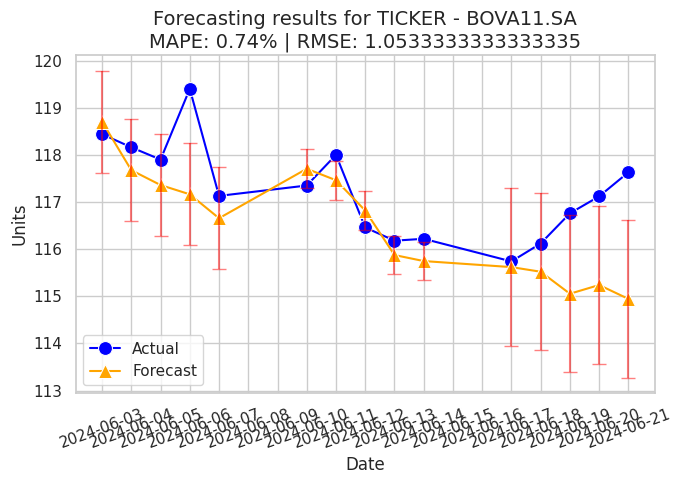

In [31]:
visualize_validation_results(validation_report_df, ticker_list[0])

## Analysing overfitting

In [7]:
feature_df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, PROCESSED_DATA_NAME), parse_dates=["DATE"])
feature_df = feature_df[feature_df[CATEGORY_COL].isin(ticker_list)]

In [8]:
X, y = split_feat_df_Xy(feature_df)

In [9]:
predictions_df, X_testing_df = stepwise_prediction(
    X=feature_df.drop(columns=[TARGET_COL, CATEGORY_COL]),
    y=feature_df[TARGET_COL],
    forecast_horizon=FORECAST_HORIZON,
    model_type=models_list[0],
    ticker=ticker_list[0],
    load_best_params=True
)

[0]	validation_0-rmse:10.38893	validation_0-logloss:-4408.22166
[20]	validation_0-rmse:1.71405	validation_0-logloss:-4408.74062
[34]	validation_0-rmse:0.78177	validation_0-logloss:-4408.74354


In [10]:
predictions_df

,DATE,ACTUAL,FORECAST,MAPE,MAE,WAPE,RMSE,MODEL_TYPE,CLASS,TRAINING_MAPE,TRAINING_RMSE
0,2024-06-17,115.74,115.619598,0.0119,1.4,0.01,1.67,XGBRegressor,Testing,0.0055,0.78
1,2024-06-18,116.12,115.521187,0.0119,1.4,0.01,1.67,XGBRegressor,Testing,0.0055,0.78
2,2024-06-19,116.76,115.054756,0.0119,1.4,0.01,1.67,XGBRegressor,Testing,0.0055,0.78
3,2024-06-20,117.12,115.239395,0.0119,1.4,0.01,1.67,XGBRegressor,Testing,0.0055,0.78
4,2024-06-21,117.63,114.945419,0.0119,1.4,0.01,1.67,XGBRegressor,Testing,0.0055,0.78


In [11]:
model = load_production_model_sklearn("BOVA11.SA")

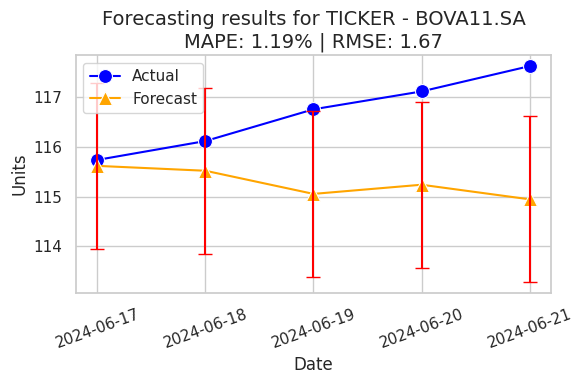